In [ ]:
from zipfile import ZipFile
file_name = '/content/BrainData.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# Import libraries
import sys
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.metrics import Precision, Recall
from IPython.display import display, clear_output
from collections import Counter
import os

# Define directories
train_dir = '/content/Brain/Brain_Tumor_Datasets/train'
test_dir = '/content/Brain/Brain_Tumor_Datasets/test'

In [ ]:
# Function to preprocess images
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 150])
    image /= 255.0
    return image

# Function to load and preprocess images from file paths
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    return preprocess_image(image)

# Function to create a dataset from a directory of images with labels
def create_dataset(directory, augment=False):
    file_list = tf.data.Dataset.list_files(directory + '/*/*')
    dataset = file_list.map(lambda x: (load_and_preprocess_image(x),
                                       0 if tf.strings.regex_full_match(x, '.*no/.*') else 1))
    if augment:
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    return dataset

# Function to check for data leakage
def check_data_leakage(train_dataset, test_dataset):
    train_images = set()
    test_images = set()

    for file in tf.data.Dataset.list_files(train_dir + '/*/*'):
        train_images.add(file.numpy())
    for file in tf.data.Dataset.list_files(test_dir + '/*/*'):
        test_images.add(file.numpy())

    leakage = train_images.intersection(test_images)
    return len(leakage) == 0

In [ ]:
# Create train and test datasets
full_train_dataset = create_dataset(train_dir, augment=True)
test_dataset = create_dataset(test_dir).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Split the full training dataset into train and validation sets
val_size = int(0.3 * len(list(full_train_dataset)))  # 30% for validation
train_size = len(list(full_train_dataset)) - val_size

train_dataset = full_train_dataset.take(train_size).shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = full_train_dataset.skip(train_size).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Check for data leakage
if not check_data_leakage(train_dataset, test_dataset):
    print("Data leakage detected!")
else:
    print("No data leakage detected.")

# Check class distribution
def check_class_distribution(dataset, dataset_name):
    class_counter = Counter()
    for _, labels in dataset:
        class_counter.update(labels.numpy())
    print(f"{dataset_name} class distribution: {class_counter}")

check_class_distribution(train_dataset, "Training")
check_class_distribution(test_dataset, "Test")

No data leakage detected.
Training class distribution: Counter({1: 2862, 0: 2047})
Test class distribution: Counter({1: 1035, 0: 717})


In [ ]:
# Define and compile the model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

model = create_model()


Epoch 1/20
154/154 [==============================] - 279s 2s/step - loss: 0.1290 - accuracy: 0.9519 - precision: 0.9325 - recall: 0.9335 - val_loss: 0.0868 - val_accuracy: 0.9677 - val_precision: 0.9418 - val_recall: 0.9377
Epoch 2/20
154/154 [==============================] - 270s 2s/step - loss: 0.1016 - accuracy: 0.9625 - precision: 0.9483 - recall: 0.9408 - val_loss: 0.0713 - val_accuracy: 0.9724 - val_precision: 0.9530 - val_recall: 0.9447
Epoch 3/20
154/154 [==============================] - 264s 2s/step - loss: 0.0839 - accuracy: 0.9711 - precision: 0.9570 - recall: 0.9477 - val_loss: 0.0667 - val_accuracy: 0.9734 - val_precision: 0.9595 - val_recall: 0.9507
Epoch 4/20
154/154 [==============================] - 265s 2s/step - loss: 0.0622 - accuracy: 0.9770 - precision: 0.9619 - recall: 0.9534 - val_loss: 0.0427 - val_accuracy: 0.9867 - val_precision: 0.9642 - val_recall: 0.9558
Epoch 5/20
154/154 [==============================] - 265s 2s/step - loss: 0.0578 - accuracy: 0.9813

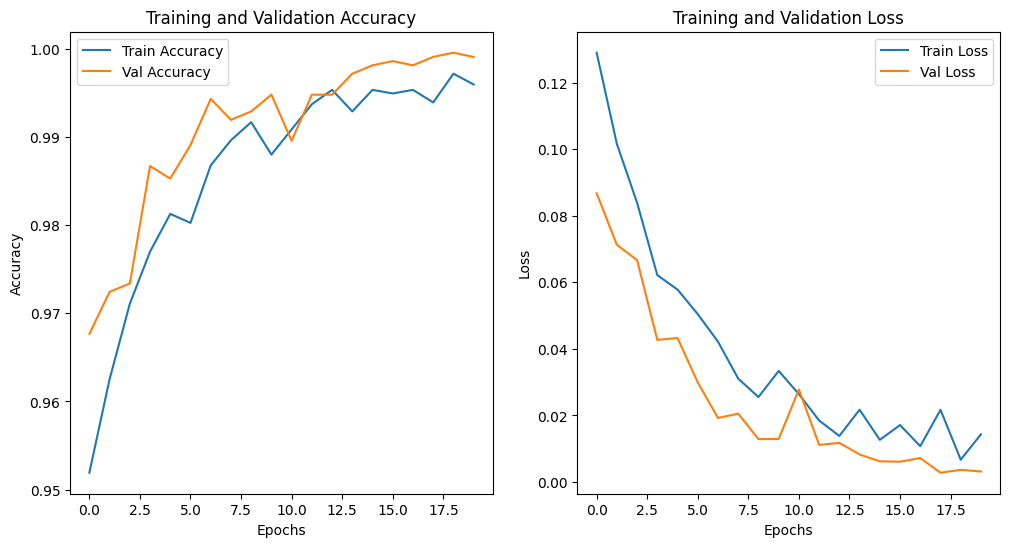

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot for training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis

# Plot for training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis

plt.show()

In [ ]:
# Evaluate the model and print the results
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')
print(f'Test precision: {precision:.2f}')
print(f'Test recall: {recall:.2f}')

55/55 [==============================] - 24s 440ms/step - loss: 0.0683 - accuracy: 0.9857 - precision: 0.9874 - recall: 0.9831
Test accuracy: 0.99
Test precision: 0.99
Test recall: 0.98


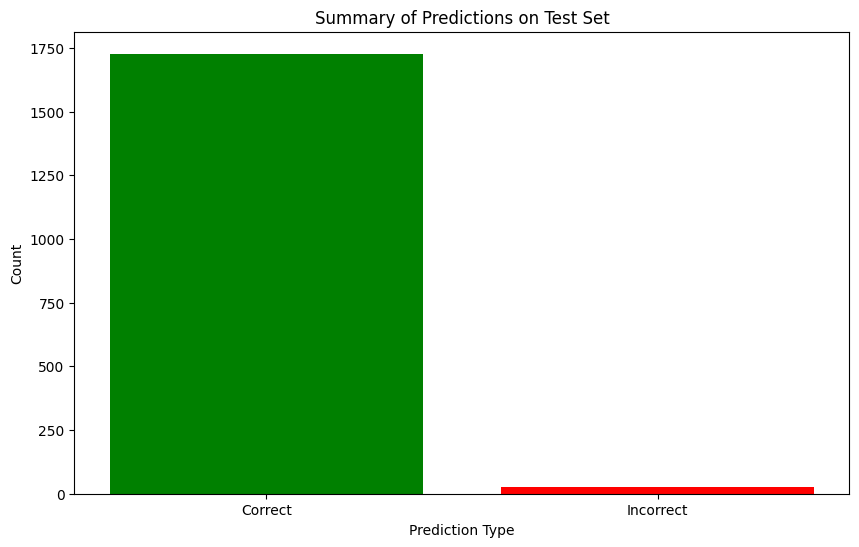

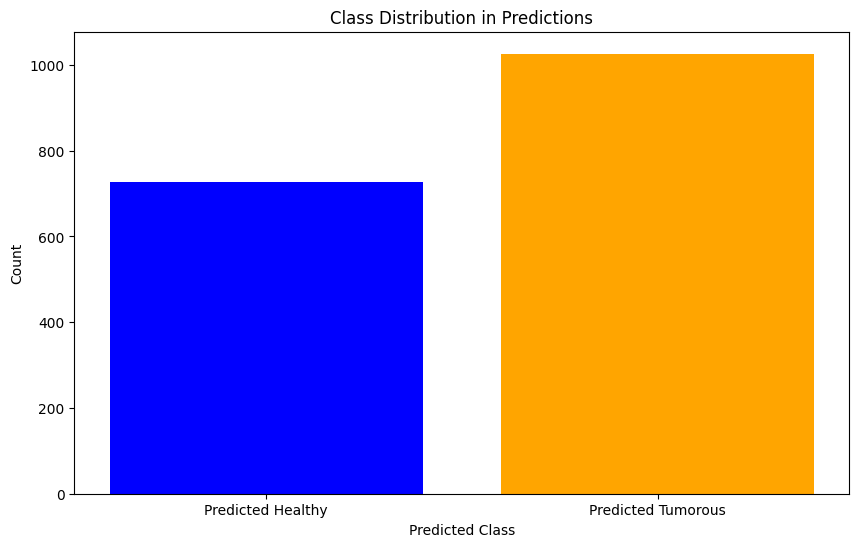

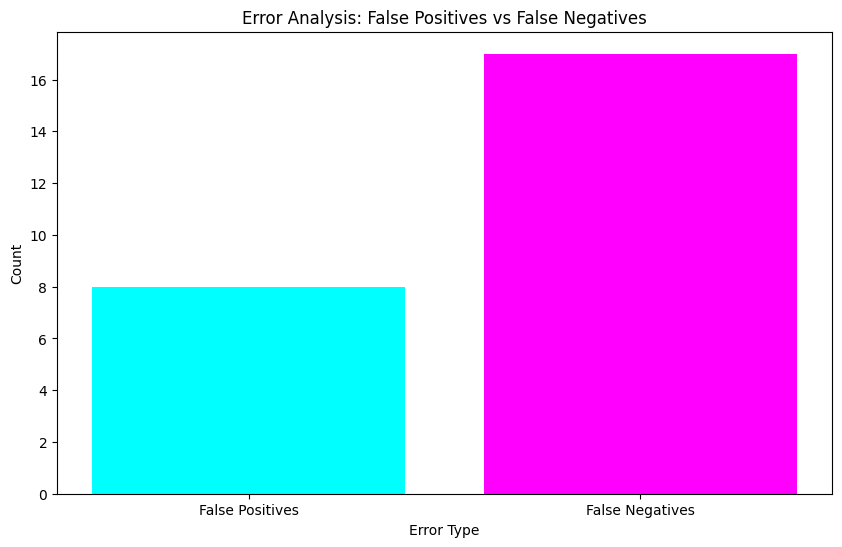

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

# Function to get predictions and compare with true labels
def get_predictions_and_labels(dataset):
    predictions, labels = [], []

    # Redirect stdout to suppress output
    original_stdout = sys.stdout
    sys.stdout = open('temp_stdout.txt', 'w')

    for images, lbls in dataset:
        preds = model.predict(images)  # Ensure input shape is (1, 150, 150, 3)
        preds = (preds > 0.5).astype(int).flatten()  # Convert predictions to binary
        predictions.extend(preds)
        labels.extend(lbls.numpy().flatten())  # Flatten the labels

    # Restore stdout
    sys.stdout.close()
    sys.stdout = original_stdout

    return np.array(predictions), np.array(labels)

# Inform the user that plots are being generated
display("Generating plot...")

# Introduce a small delay to ensure the text is visible
time.sleep(0.5)

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(test_dataset)

# Clear the "Generating plot..." text
clear_output()

# Identify correct and incorrect predictions
correct_preds = predictions == true_labels
incorrect_preds = predictions != true_labels

# Plotting

# Bar plot for correct and incorrect predictions
plt.figure(figsize=(10, 6))
plt.bar(['Correct', 'Incorrect'], [np.sum(correct_preds), np.sum(incorrect_preds)], color=['green', 'red'])
plt.title('Summary of Predictions on Test Set')
plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.show()

# Class Distribution in Predictions
plt.figure(figsize=(10, 6))
plt.bar(['Predicted Healthy', 'Predicted Tumorous'], [np.sum(predictions == 0), np.sum(predictions == 1)], color=['blue', 'orange'])
plt.title('Class Distribution in Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.show()

# Error Analysis: False Positives vs False Negatives
false_positives = np.sum((predictions == 1) & (true_labels == 0))
false_negatives = np.sum((predictions == 0) & (true_labels == 1))
plt.figure(figsize=(10, 6))
plt.bar(['False Positives', 'False Negatives'], [false_positives, false_negatives], color=['cyan', 'magenta'])
plt.title('Error Analysis: False Positives vs False Negatives')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.show()

In [ ]:
import os
import tensorflow as tf
import numpy as np
import contextlib
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
# Predict on new data
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    with suppress_stdout():
        prediction = model.predict(img_array)
    return prediction[0][0]  # Assuming binary classification, return the prediction


In [ ]:
def process_directory(directory):
    true_labels = []
    predictions = []

    healthy_count = 0
    tumorous_count = 0

    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path):
            prediction = predict_image(img_path)
            true_label = 0 if "normal" in directory else 1  # Assuming directory name contains "normal" for healthy images
            predicted_label = 1 if prediction > 0.5 else 0

            true_labels.append(true_label)
            predictions.append(predicted_label)

            if predicted_label > 0.5:
                tumorous_count += 1
            else:
                healthy_count += 1

    total_images = healthy_count + tumorous_count
    healthy_percentage = round((healthy_count / total_images) * 100, 2) if total_images > 0 else 0
    tumorous_percentage = round((tumorous_count / total_images) * 100, 2) if total_images > 0 else 0
    accuracy = round((sum([1 for i in range(len(true_labels)) if true_labels[i] == predictions[i]]) / len(true_labels)) * 100, 2)

    return healthy_count, tumorous_count, healthy_percentage, tumorous_percentage, accuracy, true_labels, predictions


In [ ]:
def plot_proportions(data, title):
    labels = data.keys()
    healthy_percentages = [data[label][2] for label in labels]
    tumorous_percentages = [data[label][3] for label in labels]

    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(x - bar_width/2, healthy_percentages, bar_width,
    alpha=opacity,
    color='g',
    label='Healthy %')

    rects2 = plt.bar(x + bar_width/2, tumorous_percentages, bar_width,
    alpha=opacity,
    color='r',
    label='Tumorous %')

    plt.xlabel('Tumor Type')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks(x, labels)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_accuracy(data, title):
    labels = data.keys()
    accuracies = [data[label][4] for label in labels]

    x = np.arange(len(labels))

    plt.figure(figsize=(12, 8))
    plt.bar(x, accuracies, color='b', alpha=0.7)
    plt.xlabel('Tumor Type')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.xticks(x, labels)
    plt.ylim(0, 100)

    for i in range(len(accuracies)):
        plt.text(x[i], accuracies[i] + 1, f'{accuracies[i]}%', ha='center')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(data, title):
    labels = data.keys()

    fig, axes = plt.subplots(1, len(labels), figsize=(20, 5))
    fig.suptitle(title)

    for i, label in enumerate(labels):
        true_labels = data[label][5]
        predictions = data[label][6]
        cm = confusion_matrix(true_labels, predictions)

        axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[i].set_title(label)
        axes[i].set_xticks(np.arange(2))
        axes[i].set_yticks(np.arange(2))
        axes[i].set_xticklabels(['Healthy', 'Tumorous'])
        axes[i].set_yticklabels(['Healthy', 'Tumorous'])

        for j in range(2):
            for k in range(2):
                axes[i].text(k, j, cm[j, k], ha='center', va='center', color='red')

        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

Normal:
  Total healthy images: 385
  Total tumorous images: 53
  Healthy percentage: 87.9%
  Tumorous percentage: 12.1%
  Accuracy: 87.9%

Pituitary Tumor:
  Total healthy images: 255
  Total tumorous images: 589
  Healthy percentage: 30.21%
  Tumorous percentage: 69.79%
  Accuracy: 69.79%

Meningioma Tumor:
  Total healthy images: 262
  Total tumorous images: 651
  Healthy percentage: 28.7%
  Tumorous percentage: 71.3%
  Accuracy: 71.3%

Glioma Tumor:
  Total healthy images: 190
  Total tumorous images: 711
  Healthy percentage: 21.09%
  Tumorous percentage: 78.91%
  Accuracy: 78.91%



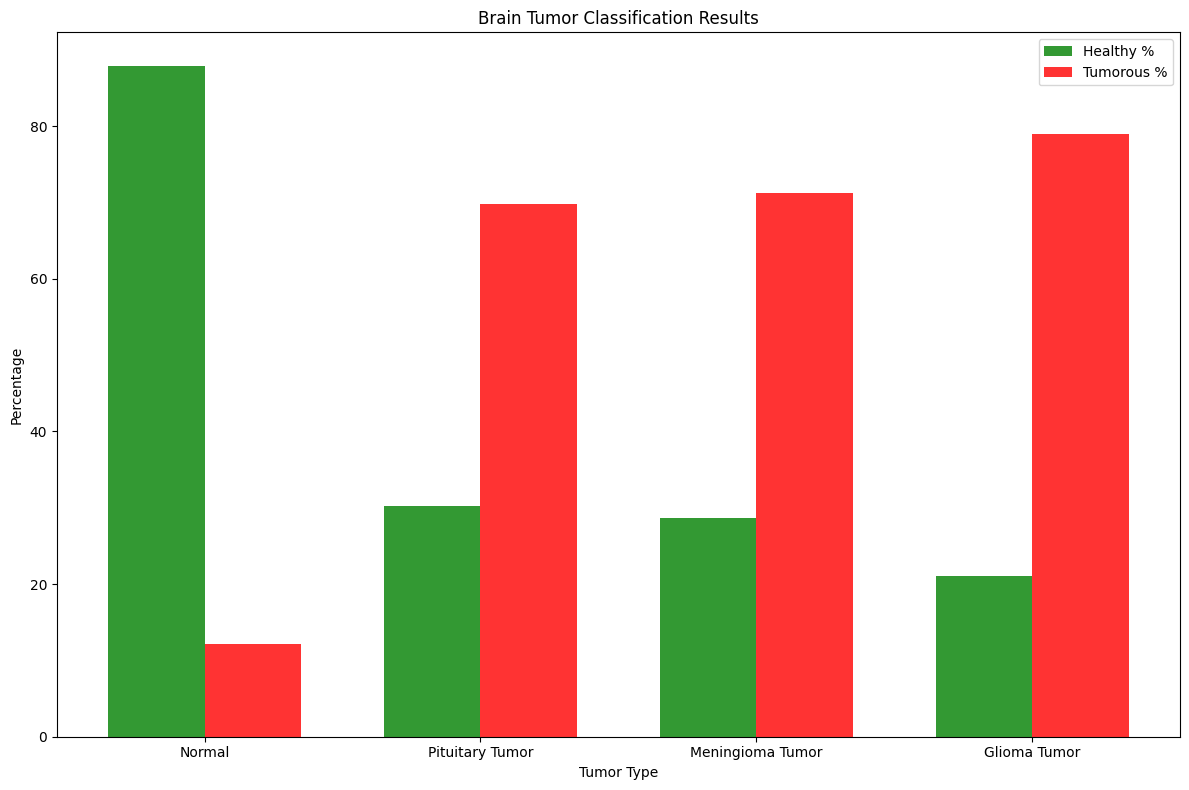

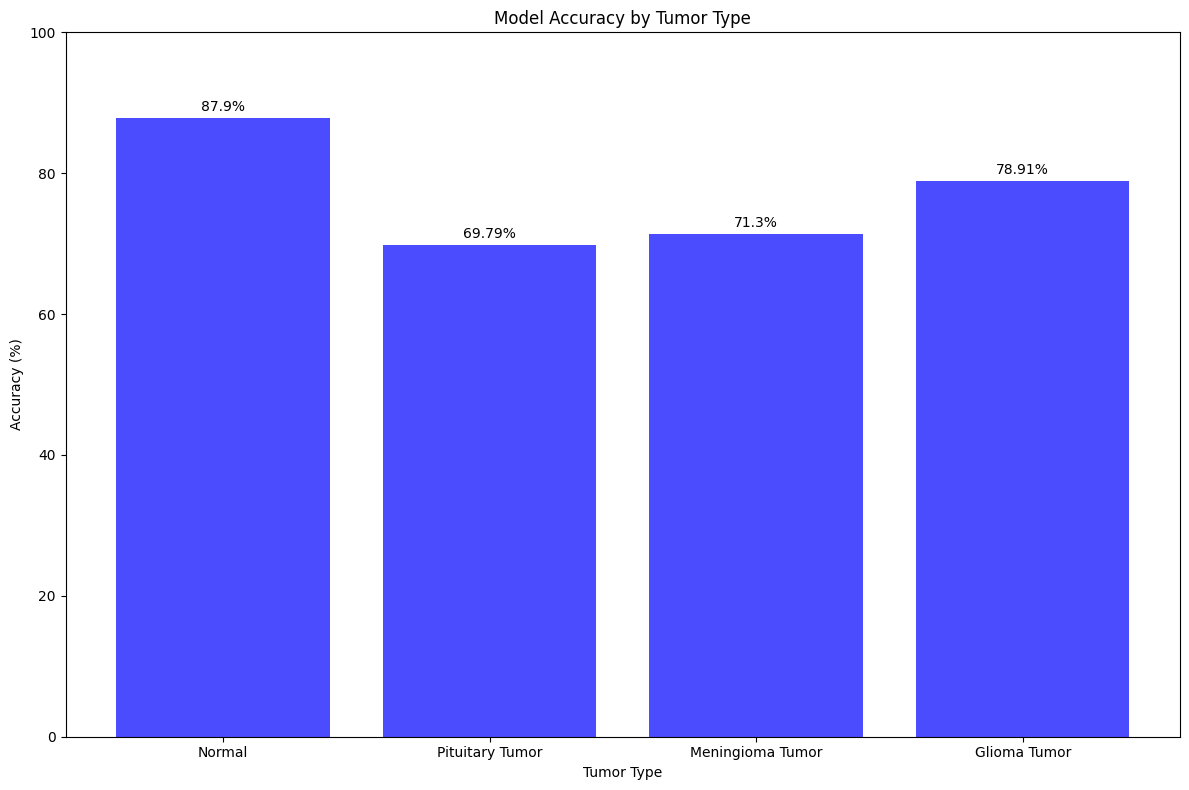

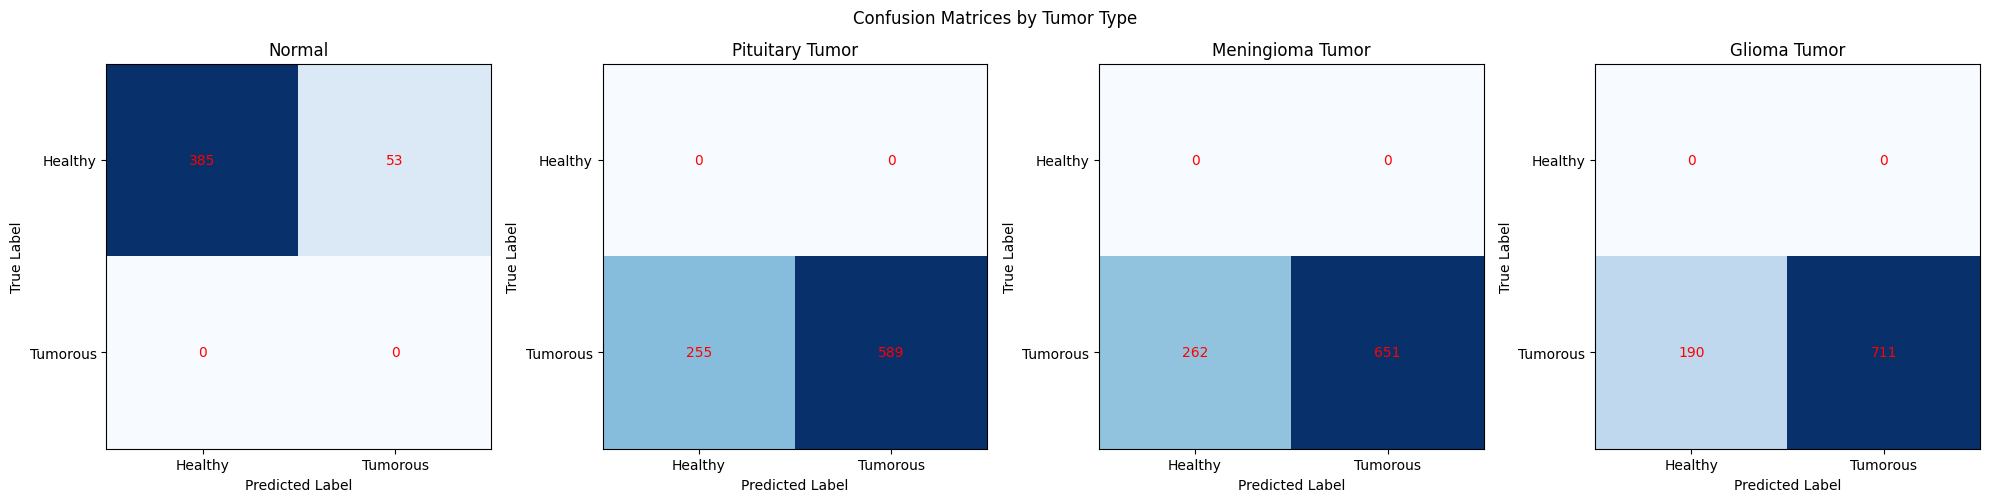

In [ ]:
# Directories for different tumor types
directories = {
    'Normal': '/content/Brain/Data/normal',
    'Pituitary Tumor': '/content/Brain/Data/pituitary_tumor',
    'Meningioma Tumor': '/content/Brain/Data/meningioma_tumor',
    'Glioma Tumor': '/content/Brain/Data/glioma_tumor'
}

# Process each directory and collect data
results = {}
for tumor_type, directory in directories.items():
    healthy_count, tumorous_count, healthy_percentage, tumorous_percentage, accuracy, true_labels, predictions = process_directory(directory)
    results[tumor_type] = (healthy_count, tumorous_count, healthy_percentage, tumorous_percentage, accuracy, true_labels, predictions)
    print(f"{tumor_type}:")
    print(f"  Total healthy images: {healthy_count}")
    print(f"  Total tumorous images: {tumorous_count}")
    print(f"  Healthy percentage: {healthy_percentage}%")
    print(f"  Tumorous percentage: {tumorous_percentage}%")
    print(f"  Accuracy: {accuracy}%\n")

# Plot results
plot_proportions(results, 'Brain Tumor Classification Results')
plot_accuracy(results, 'Model Accuracy by Tumor Type')
plot_confusion_matrices(results, 'Confusion Matrices by Tumor Type')


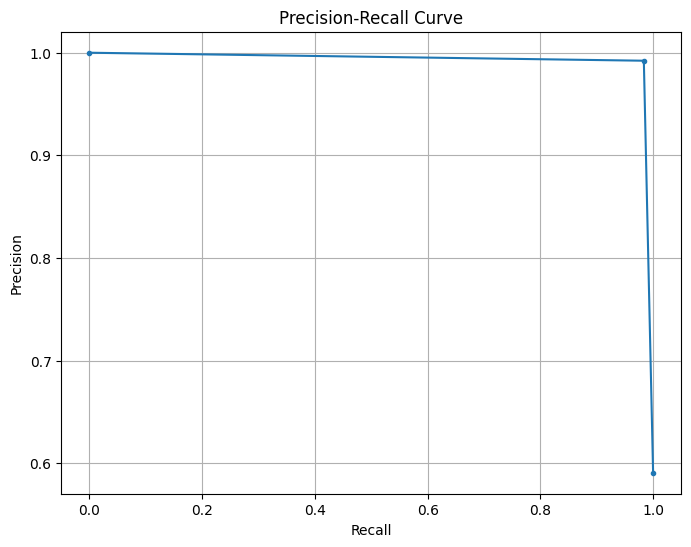

In [ ]:
from sklearn.metrics import precision_recall_curve

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(test_dataset)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

Split plots into different code blocks

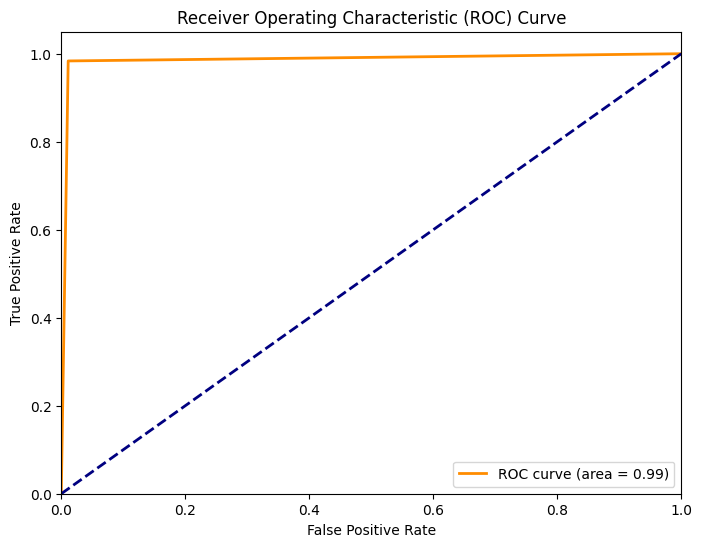

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(test_dataset)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()